In [97]:
import os
os.chdir('/home/amorales/Documents/projects/bias_2')

import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from glob import glob

import MDAnalysis as mda
import nglview as nv
import sys
sys.path.append('src/utils')
from get_BW_nomenclature import get_bw

import re
from sklearn.svm import SVC

In [98]:
# Load mutant data
# fit PCA
# plot mutants

df = pd.read_csv('data/processed/features_new.csv', index_col=0)
labels_df = df[['mutant_id', 'profile']].drop_duplicates()

/home/amorales/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [99]:
def plot_contacts(contacts, plot_motifs=True):
    
    color_dict = {i:color for i, color in enumerate(sns.color_palette())}
    
    micro_switch_dict = {'dry': range(130, 133),
                     'npxxy': range(295, 300),
                     'cwp': range(257, 261),
                     'pif': [121, 201, 254],
                     'sod_bs': [80, 120, 291, 292],
                     'toogle_s': [258],
                     '6.30': [240]}
    color_list = ['green', 'red', 'blue', 'orange',
            'purple', 'yellow', 'grey']
    

#     u = mda.Universe('data/output/topologies/topology_1.pdb')
    
    u = mda.Universe('data/interim/aligned_sims/WT/structure.psf','data/interim/wt.pdb')
    
    sel = u.select_atoms('protein or resname 8D0')

    w = nv.show_mdanalysis(sel, default=False)
    w.background = 'white'
    w.camera = 'orthographic'

    w.add_cartoon('protein', color='white')
    w.add_spacefill('[8D0]', color='lime')
    w.center()


    shape = nv.shape.Shape(view=w)
    
    if plot_motifs:
        for (ms, res), color in zip(micro_switch_dict.items(), color_list):
            res_list = list(res)
            res_str = ' '.join(map(str, res_list))

            w.add_spacefill(f'({res_str}) and .CA', color=color)

    for i, (contact, count, bw, group) in contacts.iterrows():

        r1, r2 = [res for res in contact.split('-')]
        
        sel_str = []
        
        for r in [r1, r2]:
            if r == 'LIG':
                sel_str.append('(resname 8D0 and name C1)')
            else:
                sel_str.append(f'(resid {r} and name CA)')

        space = ' '

        s = u.select_atoms(' or '.join(sel_str))
        r1_xyz, r2_xyz = s.positions[:2].tolist()

        shape.add_cylinder(r1_xyz, r2_xyz, color_dict[group], count, bw)
        
    w.background = 'white'
    return w

In [100]:
contact_columns = [col for col in df.columns if '-' in col]

In [101]:
pca = PCA(n_components=10)

In [102]:
pca_df = pca.fit_transform(df[contact_columns])
pca_df = pd.DataFrame(pca_df, columns=[f'pc{i}' for i in range(1, 11)])
pca_df[['mutant_id', 'replica', 'profile']] = df[['mutant_id', 'replica', 'profile']].reset_index(drop=True)

In [103]:
# Remove mutant 53 for being an outlier
pca_df = pca_df[pca_df.mutant_id != 53]

In [104]:
components_df = pd.DataFrame(pca.components_)
components_df = components_df.abs().transpose()
components_df['contacts'] = contact_columns

In [105]:
bw_dict = get_bw('6PT0')

# reformat dict
clean_bw_dict = {}
for k, v in bw_dict.items():
    bw = re.findall('\d+\.\d+',v)

    if not bw:
        continue

    clean_bw_dict[k[1:]] = bw[0]

In [106]:
col = 1
components_df = components_df.sort_values(col, ascending=False)
pc_df = components_df.iloc[:10][['contacts', col]]

pc_df[col] = pc_df[col].abs()
pc_df[col] = (pc_df[col] - pc_df[col].min()) / (pc_df[col].max() - pc_df[col].min()) + 1

bw_list = []

for c in pc_df.contacts:
    bw_pair = []
    for res in c.split('-'):
                
        res = clean_bw_dict.get(res, res)
            
        bw_pair.append(res)
    
    bw_list.append('-'.join(map(str, bw_pair)))
    
pc_df['bw'] = bw_list

pc_df['group'] = 1

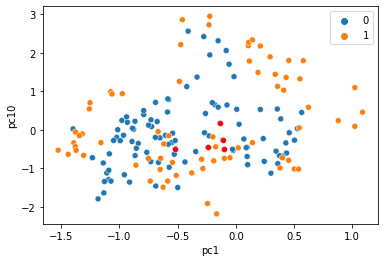

In [107]:
sns.scatterplot(data=pca_df, x='pc1', y='pc10', hue='profile')
sns.scatterplot(data=pca_df[pca_df.mutant_id == 'wt'], x='pc1', y='pc10', color='red')

plt.show()

In [108]:
df

,mutant_id,replica,242-246,116-119,166-170,215-240,34-38,127-73,124-205,23-271,...,207-227,16-26,16-33,17-26,16-30,133-226,287-39,285-291,130-135,profile
3,33,4,1.000,0.380,1.000,0.000,0.988,0.000,0.297,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0
4,33,5,1.000,0.565,0.995,0.000,1.000,0.000,0.405,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0
5,33,6,1.000,0.463,0.993,0.005,0.995,0.000,0.297,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0
6,33,7,1.000,0.472,1.000,0.000,0.990,0.018,0.325,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0
7,33,8,1.000,0.510,0.993,0.260,0.998,0.003,0.305,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,wt,4,0.993,0.537,0.998,0.000,1.000,0.472,0.357,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.003,0.003,0.000,0
249,wt,5,1.000,0.463,0.985,0.000,1.000,0.265,0.378,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0
250,wt,6,1.000,0.545,1.000,0.138,1.000,0.520,0.325,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0
251,wt,7,1.000,0.568,0.990,0.000,1.000,0.347,0.325,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0


In [109]:
def load_contact_frequencies(replica_path):
    
    mutant = replica_path.split('/')[-2]
    replica = replica_path.split('/')[-1][0]

    freqs = pd.read_csv(replica_path, 
                    header=None,
                    sep = "\t",
                    skiprows=2,
                    names=["atom1", "atom2", "freq"])

    freqs[['chain1' , 'resname1', 'resid1']] = freqs.atom1.str.split(':', expand=True)
    freqs[['chain2' , 'resname2', 'resid2']] = freqs.atom2.str.split(':', expand=True)

    # Change ligand id to "LIG"
    freqs.resid2[freqs.resname2.isin(['8D0', 'THC', 'CAN'])] = 'LIG'
    freqs.resid1[freqs.resname1.isin(['8D0', 'THC', 'CAN'])] = 'LIG'
        
    contacts = freqs[['chain1', 'resid1', 'chain2', 'resid2']].values
    contacts = [ f'{r1}-{r2}' if r1 < r2 else f'{r2}-{r1}' for c1, r1, c2, r2 in contacts]

    freqs = freqs[['freq']].transpose()

    freqs.columns = contacts

    freqs['replica'] = replica

    freqs.index = [mutant]
    
    return freqs

In [110]:
# load agonits data
freq_df_list = []

for ligand in ['canabinol', 'thc']:
    for replica_path in glob(f'data/interim/contacts/{ligand}/*frequencies.tsv'):
        replica_frequencies = load_contact_frequencies(replica_path)
        freq_df_list.append(replica_frequencies)
        

/home/amorales/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/amorales/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [111]:
freq_df = pd.concat(freq_df_list)

In [112]:
freq_df = freq_df.fillna(0)

In [113]:
freq_df

,115-82,23-275,41-44,214-216,106-22,205-207,91-95,167-172,159-163,294-297,...,177-271,185-22,161-194,185-25,173-188,254-80,100-24,178-269,178-268,305-57
canabinol,0.195,0.325,0.555,0.998,0.635,0.995,0.995,0.998,0.998,0.965,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
canabinol,0.190,0.450,0.662,0.985,0.190,0.998,0.998,0.995,0.995,0.958,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
canabinol,0.182,0.083,0.820,0.988,0.647,0.998,0.998,0.993,0.998,0.985,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
canabinol,0.228,0.217,0.645,0.993,0.605,0.998,0.995,0.995,0.998,0.970,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
thc,0.193,0.000,0.915,0.995,0.287,0.998,0.975,0.973,0.998,0.993,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
thc,0.122,0.280,0.870,0.993,0.065,0.998,0.975,0.973,0.995,0.993,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
thc,0.085,0.000,0.902,0.998,0.680,0.995,0.938,0.975,0.998,0.970,...,0.003,0.003,0.003,0.005,0.005,0.003,0.003,0.003,0.003,0.003


In [114]:
# Check columns
contacts_not_in_mutants = set(freq_df.columns) - set(df.columns)

In [115]:
freq_df[contacts_not_in_mutants]

,113-285,21-274,24-91,28-43,114-191,173-179,133-208,80-LIG,182-186,28-39,285-29,23-31,83-90,118-123,104-171,47-LIG
canabinol,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000
canabinol,0.000,0.000,0.000,0.005,0.003,0.000,0.000,0.00,0.003,0.033,0.000,0.000,0.00,0.000,0.003,0.000
canabinol,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.03,0.000,0.000,0.005,0.000,0.00,0.005,0.000,0.003
canabinol,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000
thc,0.000,0.000,0.003,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.005,0.00,0.000,0.000,0.000
thc,0.003,0.003,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.052,0.02,0.000,0.000,0.000
thc,0.000,0.000,0.000,0.000,0.000,0.005,0.003,0.00,0.000,0.000,0.007,0.005,0.00,0.000,0.000,0.000


In [116]:
freq_df.values.flatten()

array([0.195, 0.325, 0.555, ..., 0.003, 0.003, 0.003], dtype=object)

/home/amorales/.virtualenvs/bias/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 37.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


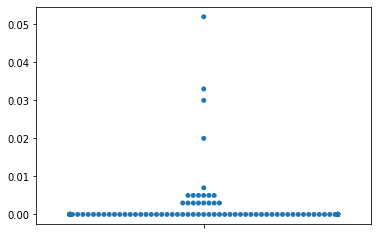

In [117]:
sns.swarmplot(y=freq_df[contacts_not_in_mutants].values.flatten())
plt.show()

In [118]:
shared_freq_df = freq_df[[col for col in freq_df.columns if col not in contacts_not_in_mutants]]

In [119]:
# project agonist data
# merge ligand data with mutant data
merged_df = pd.concat([df, shared_freq_df])

In [120]:
merged_df.fillna(0, inplace=True)

In [121]:
# take the rows of agonists
merged_agonist_df = merged_df.loc[['canabinol', 'thc']]

In [122]:
agonists_df = pca.transform(merged_agonist_df[contact_columns])

In [123]:

agonists_df = pd.DataFrame(agonists_df, columns=[f'pc{i}' for i in range(1, 11)])

In [139]:
agonists_df['ligand'] = merged_agonist_df.index

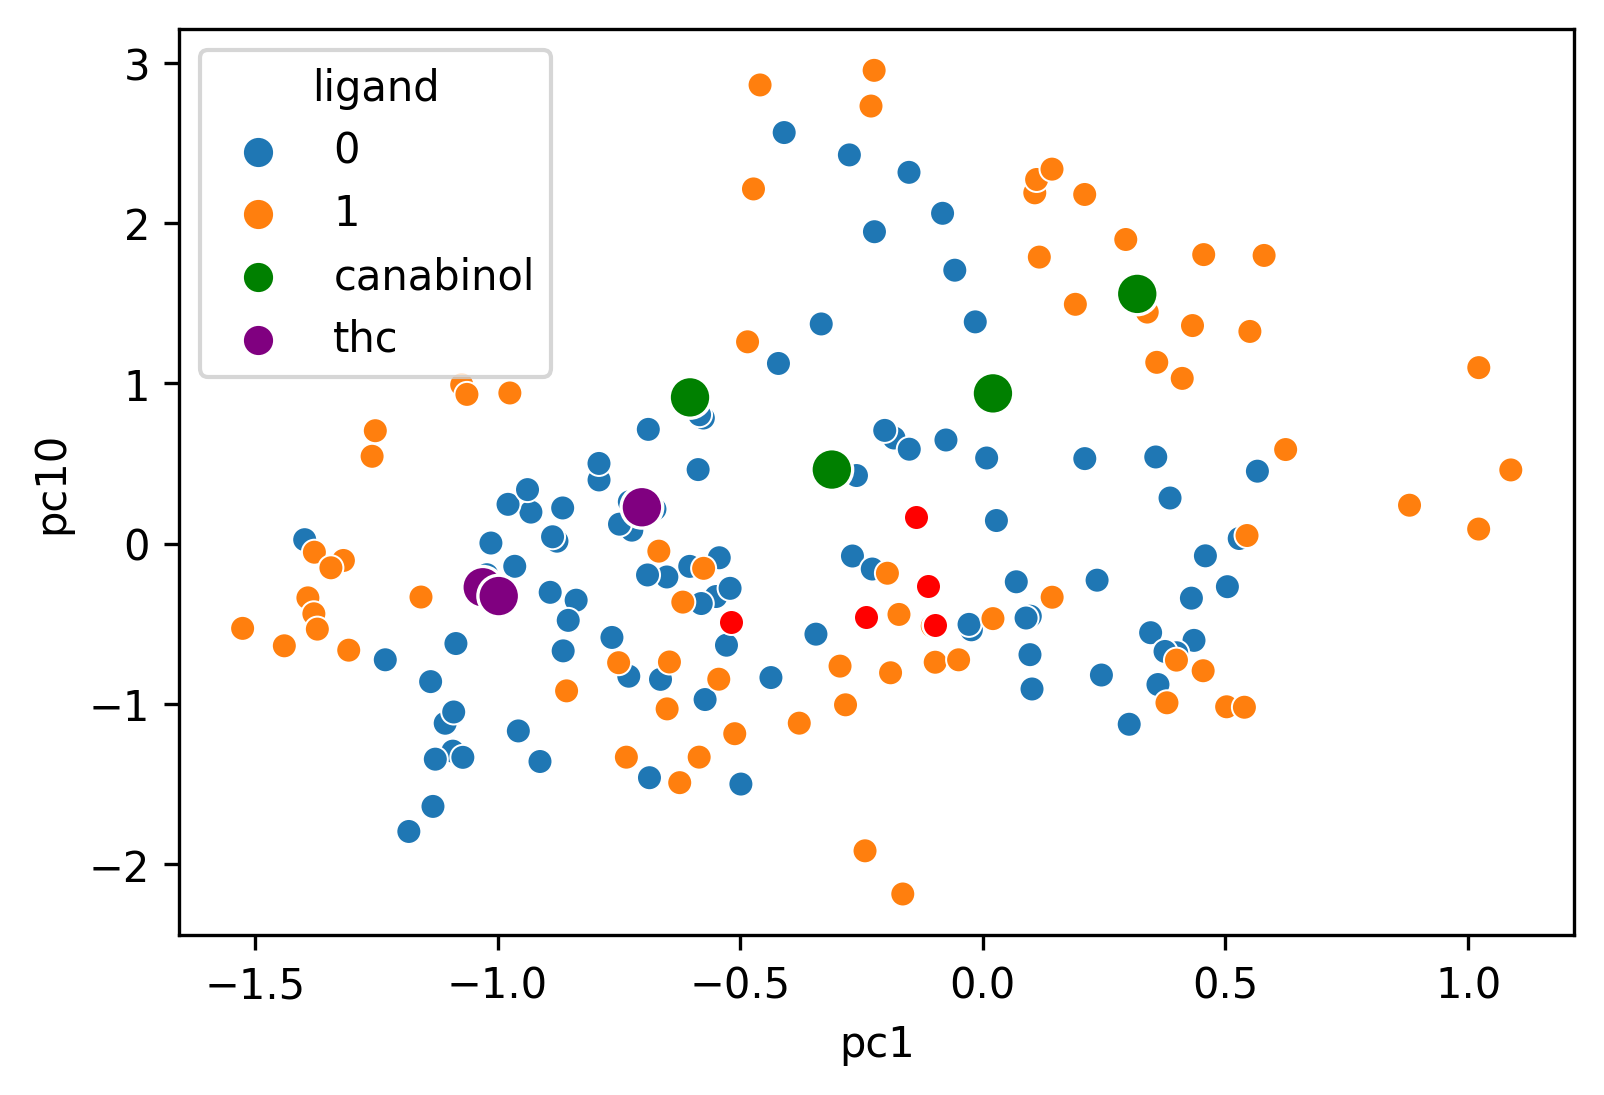

In [151]:
plt.figure(dpi=300)
sns.scatterplot(data=pca_df, x='pc1', y='pc10', hue='profile')
sns.scatterplot(data=pca_df[pca_df.mutant_id == 'wt'], x='pc1', y='pc10', color='red')

sns.scatterplot(data=agonists_df, x='pc1', y='pc10', hue='ligand', s=100, palette=['green', 'purple'])


plt.show()